In [20]:
if torch.cuda.is_available():
    print('GPU is available')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print("No GPU found")

GPU is available
Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [21]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


from helper import *


In [22]:
# Define the dataset and dataloaders with data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# No augmentation for validation and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [23]:
# Load datasets
train_dataset = CelebCariDataset(root_dir='./Project/train', transform=train_transform)
val_dataset = CelebCariDataset(root_dir='./Project/validation', transform=transform)
test_dataset = CelebCariTestDataset(root_dir='./Project/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
# Define the neural network architecture with increased dropout and using a pretrained model
class MultiLabelModel(nn.Module):
    def __init__(self, num_classes_identity, num_classes_style):
        super(MultiLabelModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze the backbone
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.fc_identity = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes_identity)
        )
        self.fc_style = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes_style)
        )

    def forward(self, x):
        features = self.backbone(x)
        identity_output = self.fc_identity(features)
        style_output = self.fc_style(features)
        return features, identity_output, style_output


num_classes_identity = 20
num_classes_style = 6
model = MultiLabelModel(num_classes_identity, num_classes_style)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

d:\Yaşar\Yazılım\Neural-Networks-With-Pytorch\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Yaşar\Yazılım\Neural-Networks-With-Pytorch\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiLabelModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [25]:
# Define the loss function and optimizer with higher weight decay
criterion_identity = nn.CrossEntropyLoss()
criterion_style = nn.CrossEntropyLoss()

def joint_loss(identity_output, style_output, identity_labels, style_labels, weight=0.5):
    loss_identity = criterion_identity(identity_output, identity_labels)
    loss_style = criterion_style(style_output, style_labels)
    return weight * loss_identity + (1 - weight) * loss_style

# Optimizer with higher weight decay and lower learning rate
optimizer = optim.Adam([
    {'params': model.fc_identity.parameters()},
    {'params': model.fc_style.parameters()}
], lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



In [26]:
num_epochs = 15
patience = 5

In [27]:
# Training loop with early stopping and tracking
best_model_wts = model.state_dict()
best_loss = float('inf')
early_stopping_counter = 0

# Lists to store the loss and accuracy values
train_losses, val_losses = [], []
train_identity_losses, val_identity_losses = [], []
train_style_losses, val_style_losses = [], []
train_identity_accuracies, val_identity_accuracies = [], []
train_style_accuracies, val_style_accuracies = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_loss_identity = 0.0
        running_loss_style = 0.0
        correct_identity = 0
        correct_style = 0
        total = 0

        for inputs, identity_labels, style_labels in dataloader:
            inputs = inputs.to(device)
            identity_labels = identity_labels.to(device)
            style_labels = style_labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                features, identity_output, style_output = model(inputs)
                loss = joint_loss(identity_output, style_output, identity_labels, style_labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_loss_identity += criterion_identity(identity_output, identity_labels).item() * inputs.size(0)
            running_loss_style += criterion_style(style_output, style_labels).item() * inputs.size(0)
            total += inputs.size(0)

            _, predicted_identity = torch.max(identity_output, 1)
            _, predicted_style = torch.max(style_output, 1)
            
            correct_identity += (predicted_identity == identity_labels).sum().item()
            correct_style += (predicted_style == style_labels).sum().item()

        epoch_loss = running_loss / total
        epoch_loss_identity = running_loss_identity / total
        epoch_loss_style = running_loss_style / total

        accuracy_identity = correct_identity / total
        accuracy_style = correct_style / total

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_identity_losses.append(epoch_loss_identity)
            train_style_losses.append(epoch_loss_style)
            train_identity_accuracies.append(accuracy_identity)
            train_style_accuracies.append(accuracy_style)
        else:
            val_losses.append(epoch_loss)
            val_identity_losses.append(epoch_loss_identity)
            val_style_losses.append(epoch_loss_style)
            val_identity_accuracies.append(accuracy_identity)
            val_style_accuracies.append(accuracy_style)

        print(f'{phase} Loss: {epoch_loss:.4f}')
        print(f'{phase} Identity Loss: {epoch_loss_identity:.4f}')
        print(f'{phase} Style Loss: {epoch_loss_style:.4f}')
        print(f'{phase} Identity Accuracy: {accuracy_identity:.4f}')
        print(f'{phase} Style Accuracy: {accuracy_style:.4f}')

        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, 'best_model.pth')
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

    scheduler.step()

    if early_stopping_counter >= patience:
        print("Early stopping")
        break


Epoch 0/14
----------
train Loss: 1.8567
train Identity Loss: 2.1529
train Style Loss: 1.5604
train Identity Accuracy: 0.2843
train Style Accuracy: 0.3657
val Loss: 1.8896
val Identity Loss: 2.6899
val Style Loss: 1.0893
val Identity Accuracy: 0.0208
val Style Accuracy: 0.6542
Epoch 1/14
----------
train Loss: 1.2610
train Identity Loss: 1.3850
train Style Loss: 1.1370
train Identity Accuracy: 0.5520
train Style Accuracy: 0.5882
val Loss: 1.9398
val Identity Loss: 3.0831
val Style Loss: 0.7965
val Identity Accuracy: 0.1292
val Style Accuracy: 0.8042
Epoch 2/14
----------
train Loss: 0.9863
train Identity Loss: 1.0164
train Style Loss: 0.9563
train Identity Accuracy: 0.6877
train Style Accuracy: 0.6466
val Loss: 2.0878
val Identity Loss: 3.4347
val Style Loss: 0.7409
val Identity Accuracy: 0.1542
val Style Accuracy: 0.7708
Epoch 3/14
----------
train Loss: 0.8600
train Identity Loss: 0.8423
train Style Loss: 0.8776
train Identity Accuracy: 0.7412
train Style Accuracy: 0.6873
val Loss: 2

In [9]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

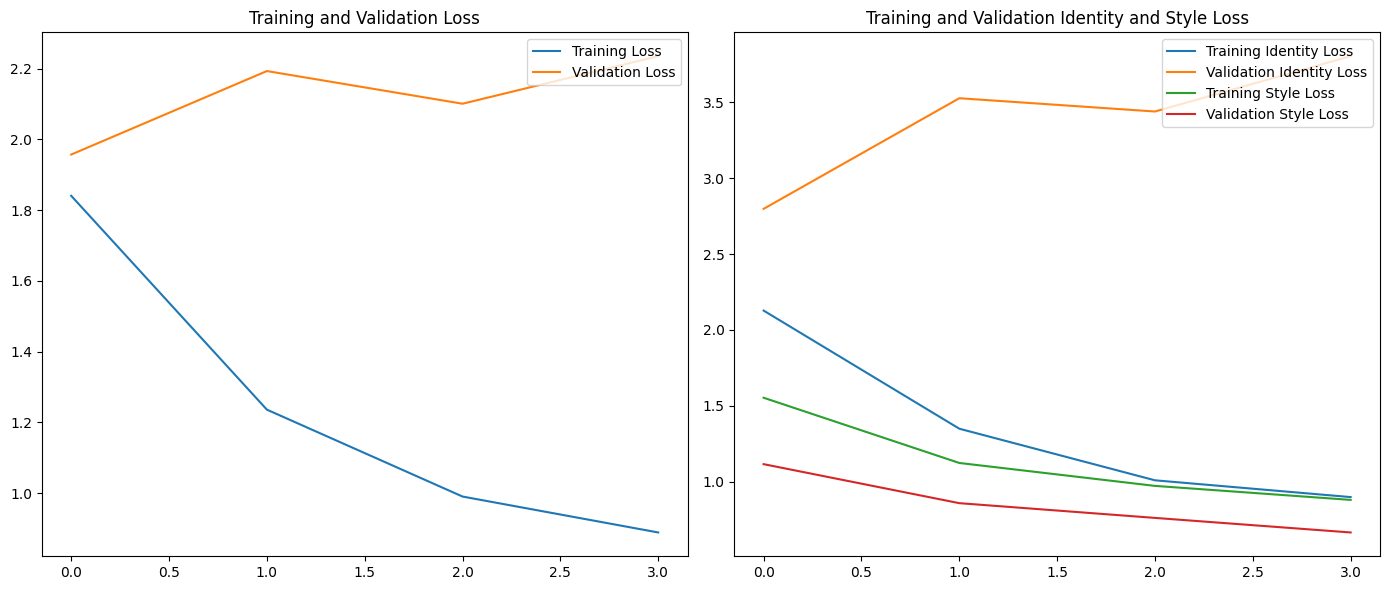

In [10]:

# Plotting the tracked metrics
epochs_range = range(num_epochs)
# Adjusting the lengths of epochs_range and metrics if needed
min_length = min(len(epochs_range), len(train_losses), len(val_losses), 
                 len(train_identity_losses), len(val_identity_losses), 
                 len(train_style_losses), len(val_style_losses), 
                 len(train_identity_accuracies), len(val_identity_accuracies),
                 len(train_style_accuracies), len(val_style_accuracies))

# Truncate all lists to the minimum length
epochs_range = epochs_range[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_identity_losses = train_identity_losses[:min_length]
val_identity_losses = val_identity_losses[:min_length]
train_style_losses = train_style_losses[:min_length]
val_style_losses = val_style_losses[:min_length]
train_identity_accuracies = train_identity_accuracies[:min_length]
val_identity_accuracies = val_identity_accuracies[:min_length]
train_style_accuracies = train_style_accuracies[:min_length]
val_style_accuracies = val_style_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_identity_losses, label='Training Identity Loss')
plt.plot(epochs_range, val_identity_losses, label='Validation Identity Loss')
plt.plot(epochs_range, train_style_losses, label='Training Style Loss')
plt.plot(epochs_range, val_style_losses, label='Validation Style Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Identity and Style Loss')

plt.tight_layout()
plt.show()




In [11]:
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [12]:

# Create and Save Gallery Embeddings Using the Validation Dataset
train_gallery = create_gallery_embeddings(model,train_dataset, device)
save_gallery_to_json(train_gallery, 'gallery_embeddings.json')


In [13]:
def evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device, similarity_threshold=0.5):
    # Load gallery embeddings from JSON file
    loaded_gallery_embeddings = read_gallery_from_json(gallery_json_path)
    print(f"Loaded gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    # Create embeddings for the probe set (validation set)
    probe_embeddings = create_gallery_embeddings(model, val_dataset, device)
    print(f"Created probe embeddings: {len(probe_embeddings)} persons")

    # Cosine similarity for gallery-probe matching
    gallery_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in loaded_gallery_embeddings.values()])
    probe_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in probe_embeddings.values()])

    cos_sim = torch.matmul(probe_tensors, gallery_tensors.T)
    cos_sim = cos_sim / (torch.norm(probe_tensors, dim=1, keepdim=True) * torch.norm(gallery_tensors, dim=1))

    # Create a mapping from person names to indices
    person_to_idx = {person: idx for idx, person in enumerate(loaded_gallery_embeddings.keys())}
    idx_to_person = {idx: person for person, idx in person_to_idx.items()}
    
    # Add an "unknown" category
    unknown_idx = len(person_to_idx)
    idx_to_person[unknown_idx] = "unknown"

    # Determine predicted labels and handle unknown faces
    predicted_indices = []
    for i, similarities in enumerate(cos_sim):
        max_similarity = torch.max(similarities).item()
        if max_similarity < similarity_threshold:
            predicted_indices.append(unknown_idx)
            person_name = list(probe_embeddings.keys())[i]
            if person_name not in loaded_gallery_embeddings:
                loaded_gallery_embeddings[person_name] = probe_embeddings[person_name]
                person_to_idx[person_name] = len(person_to_idx)
                idx_to_person[len(idx_to_person)] = person_name
                print(f"Added {person_name} to gallery")
        else:
            predicted_indices.append(torch.argmax(similarities).item())

    # True indices based on the probe set
    true_indices = []
    for person_name, embeds in probe_embeddings.items():
        if person_name in person_to_idx:
            person_idx = person_to_idx[person_name]
        else:
            person_idx = unknown_idx
        true_indices.extend([person_idx] * len(embeds))

    # Save updated gallery
    save_gallery_to_json(loaded_gallery_embeddings, gallery_json_path)

    if len(predicted_indices) != len(true_indices):
        print(f"Warning: Length mismatch - Predicted: {len(predicted_indices)}, True: {len(true_indices)}")
        min_length = min(len(predicted_indices), len(true_indices))
        predicted_indices = predicted_indices[:min_length]
        true_indices = true_indices[:min_length]

    accuracy = (torch.tensor(predicted_indices) == torch.tensor(true_indices)).float().mean().item()
    print(f'Validation Set Accuracy: {accuracy:.4f}')

    # Visualization
    # Convert indices to person names
    true_labels = [idx_to_person[idx] for idx in true_indices]
    predicted_labels = [idx_to_person[idx] for idx in predicted_indices]

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(idx_to_person.values()))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_person.values(), yticklabels=idx_to_person.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot bar chart for true vs predicted labels
    plt.figure(figsize=(12, 6))
    true_count = pd.Series(true_labels).value_counts().sort_index()
    pred_count = pd.Series(predicted_labels).value_counts().sort_index()

    print(f"True label counts: {true_count}")
    print(f"Predicted label counts: {pred_count}")

    if not true_count.empty and not pred_count.empty:
        true_count.plot(kind='bar', alpha=0.5, color='blue', position=0, label='True Labels')
        pred_count.plot(kind='bar', alpha=0.5, color='red', position=1, label='Predicted Labels')

        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.title('True vs Predicted Labels')
        plt.legend()
        plt.show()
    else:
        print("No data to plot.")


Loaded gallery embeddings: 12 persons
Created probe embeddings: 4 persons
Validation Set Accuracy: 0.0000


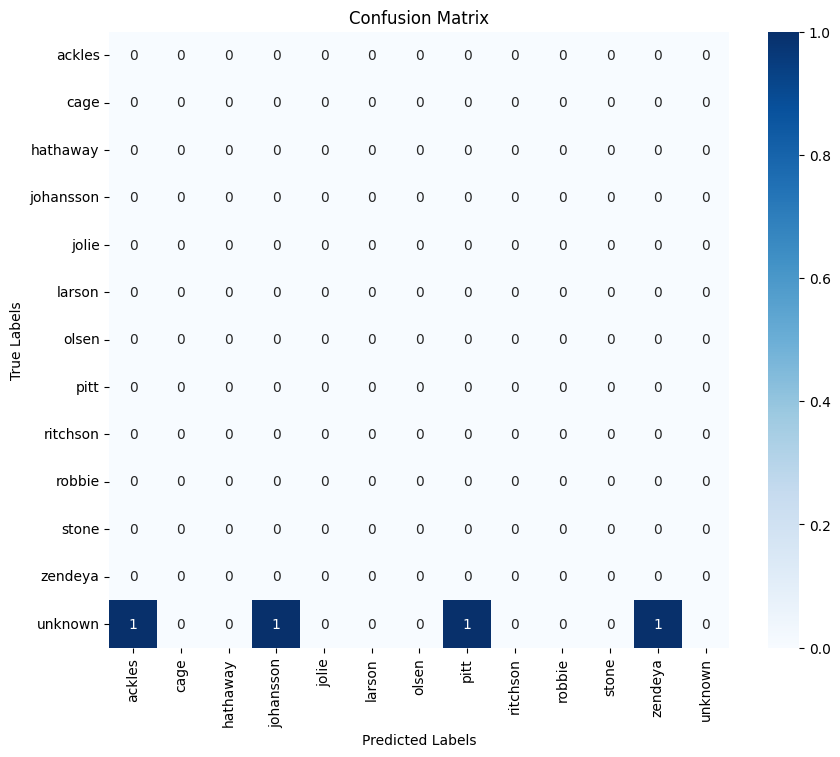

True label counts: unknown    4
Name: count, dtype: int64
Predicted label counts: ackles       1
johansson    1
pitt         1
zendeya      1
Name: count, dtype: int64


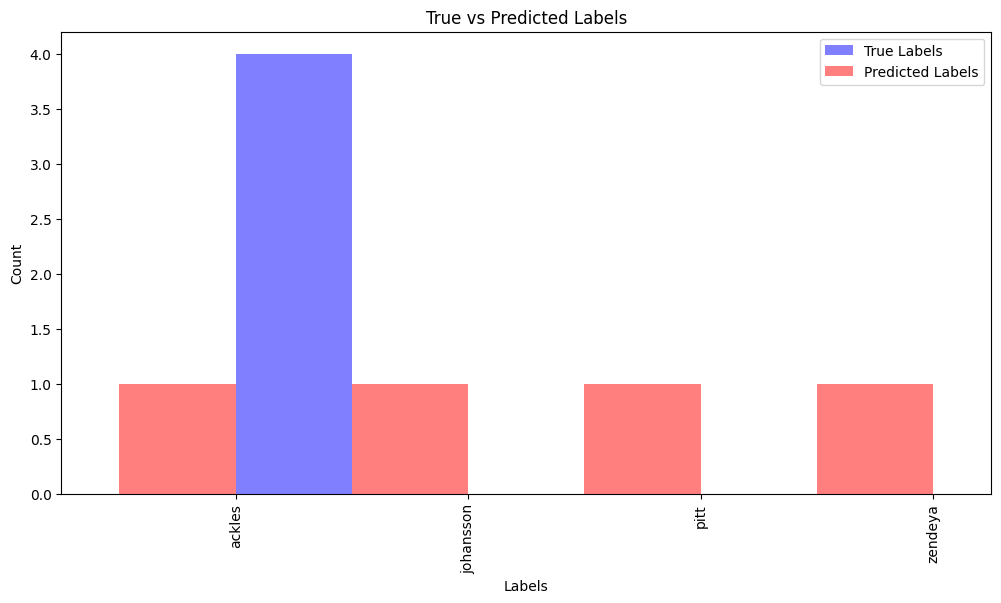

In [18]:
# Call the evaluation function after your training loop
gallery_json_path = 'gallery_embeddings.json'  
evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device)

Loaded gallery embeddings: 12 persons
Created probe embeddings: 4 persons
Validation Set Accuracy: 0.0000


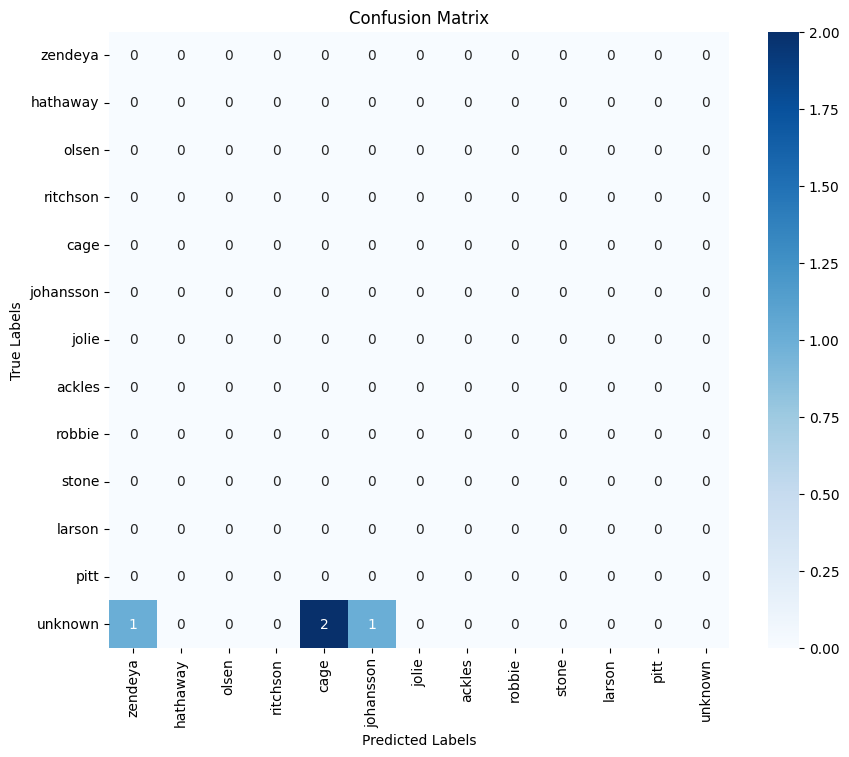

True label counts: unknown    4
Name: count, dtype: int64
Predicted label counts: cage         2
johansson    1
zendeya      1
Name: count, dtype: int64


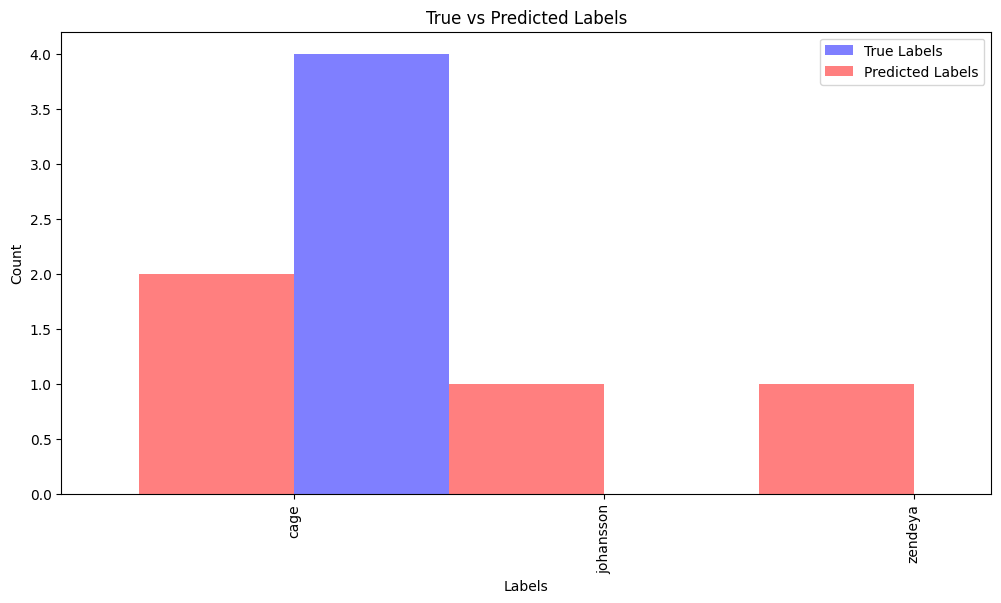

In [26]:
evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device)